## Imports

In [2]:
!pip install torch

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached torch-1.11.0-cp37-cp37m-manylinux1_x86_64.whl (750.6 MB)
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import seaborn as sb
import pandas as pd

This specific notebook focuses on using MCMC methods to determine the coefficients of a polynomial.  In other words, today we seek to perform [Bayesian linear regression](https://en.wikipedia.org/wiki/Bayesian_linear_regression) using two different MCMC algorithms discussed in class, Metropolis-Hastings (MH), and Hybrid Monte-Carlo (HMC).  The former is considered the standard for MCMC algorithms and is often the basis upon which other MCMC algorithms have been developed.  Specifically here, HMC is relevant due to its utilization of gradients, which feature prominently in Neural Networks.  As such, HMC is particuluarly suited to adoption in machine learning problems.

## Data Generation

The function below generates points from a polynomial of a specified order.  The coefficients of this polynomial are chosen randomly between -10 and 10, and will be the features in the MCMC models experimented with.  The function returns both the point values, for plotting and training within the later MCMC models, and the generated coefficients for comparison to the results of the MCMC models.

In [17]:
#generate data from a polynomial with random gaussian noise
def curve_gen(x,order):
    coeffs = []
    #generate curve
    return_val = 0
    for exp in range(order+1):
        coeff = np.random.randint(low=-10,high=10)
        coeffs.append(coeff) #store for checking results against later
        return_val += (coeff*(x**exp))

    #add randomness
    for i in range(len(return_val)):
        return_val[i] += np.random.normal(scale=10**order)
    return return_val,coeffs

Below the order of the polynomial and number of points plotted can be chosen.  After this the function $\tt{curve\_gen}$ defined above is called and the data for later experimentation generated.  The coefficients are saved in the variable $\tt{act\_coeffs}$ for later comparison.  Note too that a seed is given to numpy to enable reproducability.  This line may be removed if a different result is desired.

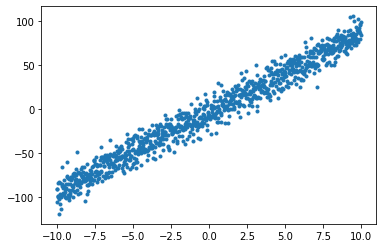

In [18]:
#for reproducability
np.random.seed(42)

order = 1
num_pts = 1000

x = np.linspace(-10,10,num_pts)
y,act_coeffs = curve_gen(x,order)

plt.plot(x,y,'.')
plt.show()

## Bayesian Functions
Here functions are defined for the calculation of the posterior distribution.  In particular we need both the prior and the likelihood for the calculation of the posterior.  According to Bayes' theorem, knowing these two terms along with the evidence (i.e. probability of the specific data being chosen) is all that is needed to calculate the posterior.  Bayes' theorem according to the variables defined in this document is presented below.

$$p(\beta|X,Y) = \cfrac{p(Y|X,𝜷)p(𝜷)}{p(Y|X)}$$

**Question: Why is there no equation for the evidence below?  Why is it not needed with MCMC methods?**

With linear regression (not only Bayesian linear regression), it's often useful to calculate a mathematical object known as the design matrix.

A general polynomial curve of order $i$ can be constructed as below, where $\beta_i$ is the coefficient on $x^i$.  Note that $\beta_0$ is the y-intercept.

$$y = \sum_{i=0}^i\beta_ix^i$$

Rather than using a sum, this equality can be equivalently written using vector multiplication.

$$y = 𝝓^T𝜷$$

$$𝝓 = \begin{pmatrix}
x^0 \\
x^1 \\
\vdots\\
x^i
\end{pmatrix} = 
\begin{pmatrix}
1 \\
x^1 \\
\vdots\\
x^i
\end{pmatrix}, 
𝜷 = \begin{pmatrix}
\beta_0 \\
\beta_1 \\
\vdots\\
\beta_i
\end{pmatrix}$$

In the case of multiple datapoints the vector $𝝓$ becomes the design matrix $𝜱$.

$$
𝜱 = 
\begin{pmatrix}
1 & x_0^1 & . . . & x_0^i\\
1 & x_1^1 & . . . & x_1^i\\
\vdots & \vdots & \ddots & \vdots\\
1 & x_i^1 & . . . & x_i^i
\end{pmatrix}
$$

Therefore, $Y = 𝜱𝜷$ in the case of multiple data points.  It is left to the student to write the function $\tt{design\_mat}$, which is intended to return a design matrix.  As well, the return function for the likelihood is left empty.  This needs to return the likelihood of $Y$ given $𝜷$ and $X$.  As a hint, it's useful to consult both the other functions compelted below as well as other online sources.  [This](https://alpopkes.com/posts/machine_learning/bayesian_linear_regression/) page, [this](https://letianzj.github.io/mcmc-linear-regression.html) page, and [this](https://letianzj.github.io/bayesian-linear-regression.html) page are recommended.

In [19]:
def design_mat(x, order):
  #TODO: Write the function which will return the design matrix.
    exps = np.arange(order+1)
    return (x ** exps.reshape(-1, 1)).T

def likelihood(beta,x,y):
    #order is one less than the length of beta
    des_mat = design_mat(x,len(beta)-1)
    y_pred = des_mat@beta
    mu = y_pred
    sig = 10**order
    norm = scipy.stats.norm(loc=y_pred, scale=10**order)
    return norm.logpdf(y)

def prior(beta):
    norm = scipy.stats.norm(loc=0,scale=10**order)
    return norm.pdf(beta)

def posterior(beta,x,y):
    like = likelihood(beta,x,y)
    pr = prior(beta)
    return np.sum(like)*np.ones(len(pr))+np.log(pr)

## The Algorithms!

With the Bayesian definitions above it's now time to define our algorithms.  The task today is to write two algorithms, Metropolis-Hastings and Hybrid Monte-Carlo.  Very little code is provided for you.  While I was implementing these, the best source was the pseudo-code from the paper, followed closely by the links provided above.  However, if you get stuck feel free to ask one of us in class or take a look at the key provided!

**Question: Refer to Figure 5 in the paper, specifically the 5th line with the minimum function.  Is it necessary to have the proposal distribution q when calculating the acceptance rate?  If so why, if not why not?**

I believe the answer is yes, the proposed distribution is necessary because the paper relies on the q distribution for calculating the term associated with rejection.

I struggled hard to implement this myself. I relied on the key.

In [22]:
#TODO: Implement Metropolis-Hastings algorithm
def mh(order,steps=10000):
  betas = [np.zeros(order+1)] #initial guess
  for i in range(steps):
    if (i+1)%(steps/100) == 0:print("Step ",i+1,"/",steps,sep='') #print steps to check progress
    u = np.random.uniform(size=order+1)
    beta_prop = np.random.normal(size=order+1,loc=betas[-1],scale=0.1)
    while np.abs(beta_prop).max()>10: 
      beta_prop = np.random.normal(size=order+1,loc=betas[-1],scale=0.1)
    #since the proposal is symmetric, no need for q in acceptance
    acc = np.minimum(np.ones(order+1),np.exp(posterior(beta_prop,x,y)-posterior(betas[-1],x,y)))
    beta_selector = (u<acc).astype(int)
    beta_selectee = np.append([betas[-1]],[beta_prop],axis=0)

    new_beta = np.diagonal(beta_selectee.T[:,beta_selector])
    betas.append(new_beta)
  return betas

Below run your implemented Metropolis-Hastings.

In [23]:
betas = mh(order)

Step 100/10000
Step 200/10000
Step 300/10000
Step 400/10000
Step 500/10000
Step 600/10000
Step 700/10000
Step 800/10000
Step 900/10000
Step 1000/10000
Step 1100/10000
Step 1200/10000
Step 1300/10000
Step 1400/10000
Step 1500/10000
Step 1600/10000
Step 1700/10000
Step 1800/10000
Step 1900/10000
Step 2000/10000
Step 2100/10000
Step 2200/10000
Step 2300/10000
Step 2400/10000
Step 2500/10000
Step 2600/10000
Step 2700/10000
Step 2800/10000
Step 2900/10000
Step 3000/10000
Step 3100/10000
Step 3200/10000
Step 3300/10000
Step 3400/10000
Step 3500/10000
Step 3600/10000
Step 3700/10000
Step 3800/10000
Step 3900/10000
Step 4000/10000
Step 4100/10000
Step 4200/10000
Step 4300/10000
Step 4400/10000
Step 4500/10000
Step 4600/10000
Step 4700/10000
Step 4800/10000
Step 4900/10000
Step 5000/10000
Step 5100/10000
Step 5200/10000
Step 5300/10000
Step 5400/10000
Step 5500/10000
Step 5600/10000
Step 5700/10000
Step 5800/10000
Step 5900/10000
Step 6000/10000
Step 6100/10000
Step 6200/10000
Step 6300/10000
S

Plot the results of your Metropolis-Hastings implementation.

Below is a histogram of your MCMC results along with a red line indicating the true coefficient value.

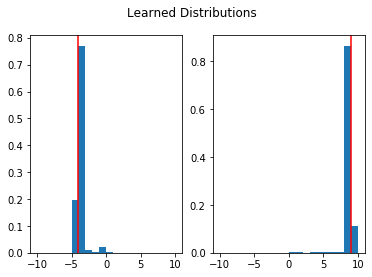

In [24]:
fig, axes = plt.subplots(1, order+1)
fig.suptitle('Learned Distributions')
for i in range(len(axes)):
  axes[i].hist(np.array(betas)[:,i],density=True,range=(-10,10),bins=20)
  axes[i].axvline(x=act_coeffs[i],color='r')

Below a function $\tt{coeff\_plot}$ is provided which takes in a series of coefficients and returns y-values for plotting.  As well, the function $\tt{gen\_coeffs}$ takes in your calculated betas and returns the most likely coefficient to 0.01 accuracy.

In [25]:
def coeff_plot(coeffs,x):
  #generate curve
  return_val = 0
  for exp in range(len(coeffs)):
    return_val += (coeffs[exp]*(x**exp))
  return return_val
def gen_coeffs(betas):
  coeffs = []
  for i in range(len(betas[0])):
    binned = np.histogram(np.array(betas)[:,i],bins=1000,range=(-10,10))
    coeffs.append(binned[1][np.argmax(binned[0])])
  return coeffs

Plot the random walk of MH algorithm throughout the feature space.

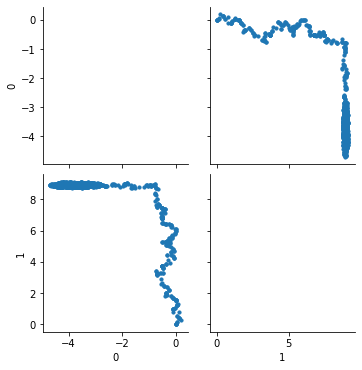

In [26]:
df = pd.DataFrame(betas)
g = sb.PairGrid(df)
g.map_offdiag(plt.scatter,s=10)
plt.show()

Compare the results of MH to the actual coefficients used.

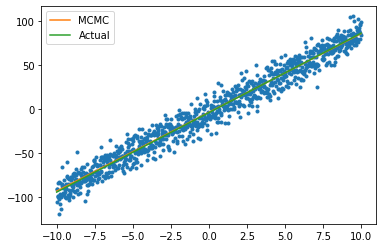

In [27]:
plt.plot(x,y,'.')
plt.plot(x,coeff_plot(gen_coeffs(betas),x),label='MCMC')
plt.plot(x,coeff_plot(act_coeffs,x),label='Actual')
plt.legend()

Before implementing HMC you will need to define the gradient of the posterior.  This is done for you.  However, the below function relies heavily on the gradient of the likelihood which is left mostly undefined.

Hint: What is the derivative of a normal distribution?  How do you account for the multiple features?  Do we already have easy access to such an object?

In [28]:
def likelihood_grad(beta,x,y):
  #order is one less than the length of beta
  #order is one less than the length of beta
    des_mat = design_mat(x,len(beta)-1)
    y_pred = des_mat@beta
    
    mu = y_pred
    sig = 10**order

    norm_dist = scipy.stats.norm(loc=mu, scale=sig).pdf(y)
    coeff = (y_pred-y)/(10**(2*order))

    return des_mat.T * (norm_dist*coeff)


def posterior_grad(beta,x,y):
  like = likelihood_grad(beta,x,y)
  pr = prior(beta)
  return np.sum(like,axis=1)+pr

I also struggled on implementing this and relied on the key...

In [32]:
#TODO: Implement Hybrid Monte-Carlo algorithm
def hmc(order, steps=10000,L=10,rho=0.1):
    betas = [np.zeros(order+1)]
    for i in range(steps):
        if (i+1)%(steps/100) == 0:print("Step ",i+1,"/",steps,sep='')
        v = np.random.uniform(size=order+1)
        u = np.random.normal(size=order+1)

        u_l = u + rho*posterior_grad(betas[-1],x,y)/2
        beta_l = betas[-1].copy()

        for l in range(L):
            beta_l += rho*u_l

            if l<(L-1): u_l += rho*posterior_grad(beta_l,x,y)
            else: u_l += (rho/2)*posterior_grad(beta_l,x,y)

        acc_ratio = np.exp(posterior(beta_l,x,y)-posterior(betas[-1],x,y))
        u_exp = np.exp(-0.5 * (np.dot(u_l,u_l) - np.dot(u,u)))
        acc = np.minimum(np.ones(order+1), acc_ratio*u_exp)

        beta_selector = (v<acc).astype(int)
        beta_selectee = np.append([betas[-1]],[beta_l],axis=0)

        new_beta = np.diagonal(beta_selectee.T[:,beta_selector])
        betas.append(new_beta)
    return betas

Below run your implemented Hybrid Monte-Carlo.

In [33]:
betas = hmc(order)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


Step 100/10000
Step 200/10000
Step 300/10000
Step 400/10000
Step 500/10000
Step 600/10000
Step 700/10000
Step 800/10000
Step 900/10000
Step 1000/10000
Step 1100/10000
Step 1200/10000
Step 1300/10000
Step 1400/10000
Step 1500/10000
Step 1600/10000
Step 1700/10000
Step 1800/10000
Step 1900/10000
Step 2000/10000
Step 2100/10000
Step 2200/10000
Step 2300/10000
Step 2400/10000
Step 2500/10000
Step 2600/10000
Step 2700/10000
Step 2800/10000
Step 2900/10000
Step 3000/10000
Step 3100/10000
Step 3200/10000
Step 3300/10000
Step 3400/10000
Step 3500/10000
Step 3600/10000
Step 3700/10000
Step 3800/10000
Step 3900/10000
Step 4000/10000
Step 4100/10000
Step 4200/10000
Step 4300/10000
Step 4400/10000
Step 4500/10000
Step 4600/10000
Step 4700/10000
Step 4800/10000
Step 4900/10000
Step 5000/10000
Step 5100/10000
Step 5200/10000
Step 5300/10000
Step 5400/10000
Step 5500/10000
Step 5600/10000
Step 5700/10000
Step 5800/10000
Step 5900/10000
Step 6000/10000
Step 6100/10000
Step 6200/10000
Step 6300/10000
S

Plot the random walk of HMC throughout the feature space.

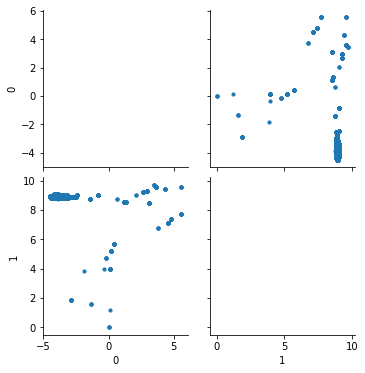

In [34]:
df = pd.DataFrame(betas)
g = sb.PairGrid(df)
g.map_offdiag(plt.scatter,s=10)
plt.show()

Compare the results of HMC to the actual coefficients used.

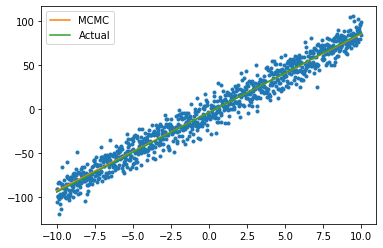

In [35]:
plt.plot(x,y,'.')
plt.plot(x,coeff_plot(gen_coeffs(betas),x),label='MCMC')
plt.plot(x,coeff_plot(act_coeffs,x),label='Actual')
plt.legend()